### Learning sparse coding representation by experimenting with MNIST dataset. 

##### I am following Hugo Larochell's video series on sparse coding: https://www.youtube.com/watch?v=7a0_iEruGoM

#### First loading MNIST dataset. I am using this python script from: https://github.com/hsjeong5/MNIST-for-Numpy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mnist
import numpy as np

In [2]:
mnist.init()

Download complete.
Save complete.


In [3]:
type(mnist)

module

In [4]:
x_train, t_train, x_test, t_test = mnist.load()

In [5]:
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
pd.DataFrame(t_train).head()

,0
0,5
1,0
2,4
3,1
4,9


In [6]:
plot_samples(x_train,5,5)

NameError: name 'plot_samples' is not defined

In [7]:
a = np.zeros((10,10))
k=0
for i in range(0,10):
    for j in range(0,10):
        a[i][j] = t_train[k]
        k+=1

In [8]:
a

array([[5., 0., 4., 1., 9., 2., 1., 3., 1., 4.],
       [3., 5., 3., 6., 1., 7., 2., 8., 6., 9.],
       [4., 0., 9., 1., 1., 2., 4., 3., 2., 7.],
       [3., 8., 6., 9., 0., 5., 6., 0., 7., 6.],
       [1., 8., 7., 9., 3., 9., 8., 5., 9., 3.],
       [3., 0., 7., 4., 9., 8., 0., 9., 4., 1.],
       [4., 4., 6., 0., 4., 5., 6., 1., 0., 0.],
       [1., 7., 1., 6., 3., 0., 2., 1., 1., 7.],
       [9., 0., 2., 6., 7., 8., 3., 9., 0., 4.],
       [6., 7., 4., 6., 8., 0., 7., 8., 3., 1.]])

#### ZCA whitening the values
Before running a sparse coding algorithm, it is beneficial to remove "obvious" structure from the data. 

- Normalize such that mean is 0 and covariance is the identity
- This will remove the 1st and 2dn order statistical structure.


###### Running ZCA with all the training data causes kernel to die. Need to find out another way, doing it in batch definitely messes up the results of whitening.

In [9]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

In [10]:
ZCA_mat = zca_whitening_matrix(x_train[0:1000])
ZCA_whitened = np.dot(ZCA_mat, x_train[0:1000]) # project X onto the ZCAMatrix


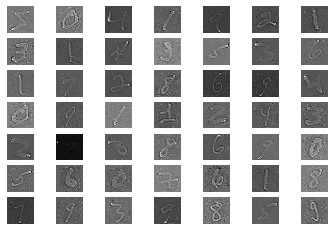

In [15]:
plot_samples(ZCA_whitened, 7,7)

### Using ISTA to infer the sparse codes

In [8]:
convergenceThreshold = 5e-4
sparsityTerm = 0.5
maxIterations = 10000
learningRate = 0.0001

def shrink(a,b):
    sign = [1 if x>0 else -1 for x in a.flatten()]
    shrinkedValue = sign * np.clip(np.absolute(a) - b,0,None)
    
    return shrinkedValue

def ISTA(X, h, D):
    prevObjectiveFunction = 0
    i = 0
    while True:
        # Iterations i
        i +=1
        
        Y = h@D
        objectiveFunction = 0.5 * np.sum((X-Y)**2) + sparsityTerm * np.sum(np.absolute(h))
        diffObjectiveFunction = abs(objectiveFunction - prevObjectiveFunction)
        
        # Break from loop once the ISTA converges or reaches maxIterations
        if(diffObjectiveFunction < convergenceThreshold or i > maxIterations):
            break
        
        prevObjectiveFunction = objectiveFunction

        h = h - learningRate * ((Y-X)@ D.T)
        h = shrink(h, learningRate * sparsityTerm)
        
#     print("h=",h, "\nX = ", X, "\nY = ",h@D,"\n objFunc = ", objectiveFunction, "\n i = ",i , "\n")
    
    return h

In [9]:
X = np.array([10, 25, 33, 42, 51, 68, 36, 88, 92])
D = np.array([[0, 1, 1, 1, 0, 0, 1, 1, 1],
              [2, 2, 2, 2, 2, 2, 2, 2, 2],
              [3, 3, 3, 3, 3, 3, 3, 3, 3],
              [4, 4, 4, 4, 4, 4, 4, 4, 4],
              [5, 5, 5, 5, 5, 5, 5, 5, 5]
              ])
h = np.array([1,1,1,1,1])

In [10]:
ISTA(X, h, D)

array([8.34805124, 1.86624116, 2.54856174, 3.23088232, 3.9132029 ])

## Dictionary Learning with block coordinate descent

In [11]:
np.random.normal(size=[100])

array([ 0.47758748, -0.55109025, -0.04859929, -1.62846107, -0.06642198,
        0.81686305, -0.42442636,  0.19310723, -0.52154078,  0.53460303,
        2.44031353,  0.61990601, -0.34845924,  0.66656025, -0.93069523,
       -1.15700458,  0.63520126, -1.55576454, -0.23908966, -0.02445776,
       -0.16370848, -0.24814052, -0.18972359, -1.07827586, -1.43640199,
       -1.24740879,  0.19796847,  0.70984852, -1.34393025,  1.83829477,
       -0.79302421,  1.17390754,  0.36498039, -1.75350098,  2.23368913,
       -0.40948842,  0.24200181,  0.39447191, -0.57915264, -1.40642055,
       -0.34776436,  1.14416455,  1.21640569, -1.03669929,  1.10972336,
        0.85899774,  1.69289361, -1.30940891,  0.40814707, -0.30339389,
        0.11188613, -1.02328926,  0.20079658, -1.59229155,  0.67843403,
        1.33653664, -0.72888183,  0.66867218, -1.70890352, -0.79305759,
        0.09743941, -0.54778545,  0.72233657,  0.90546912,  0.02643497,
        0.96408337, -0.3882776 ,  0.74929668, -0.78942173, -0.03

In [12]:
def initializeHiddenLayer(numOfAtoms = 10000):
    hInit= np.abs(np.random.normal(size=[numOfAtoms]))
    # Unit normalize the hidden layers atoms
    rowSum = hInit.sum()
    h = hInit / rowSum
    return h
    
    
def initializeDictionary(X, numOfAtoms = 10000):
    DInit= np.abs(np.random.normal(size=[numOfAtoms, X.shape[1]]))
    # Unit normalize the Dictionary atoms
    rowSum = DInit.sum(axis = 1)
    D = DInit / rowSum[:, np.newaxis]
    return D
    

In [24]:
def dictLearningBlockDescent(XBatch, D):
    prevObjectiveFunction = 0
    i = 0
    hBatch = np.array([])
    while True:
        # Iterations i
        i +=1
        
        # ISTA for each X in XBatch and store hBatch
        for X in XBatch:
            h = initializeHiddenLayer(D.shape[0])
            h = ISTA(X, h, D)
            hBatch = np.vstack([hBatch, h]) if hBatch.size else h
        
        # Check convergence of dictionary learning
        YBatch = hBatch@D
        objectiveFunction = 0.5 * np.sum((XBatch-YBatch)**2) + sparsityTerm * np.sum(np.absolute(hBatch))
        diffObjectiveFunction = abs(objectiveFunction - prevObjectiveFunction)
        
        # Break from loop once the ISTA converges or reaches maxIterations
        if(diffObjectiveFunction < convergenceThreshold or i > maxIterations):
            break
        
        prevObjectiveFunction = objectiveFunction
        
        # Block coordinate descent
        A = hBatch.T @ hBatch
        B = hBatch.T @ XBatch
        
        # Iterating for each atom
        for atomIndex, atom in enumerate(D):


            updatedAtom = (1/A[atomIndex, atomIndex]) * (B[atomIndex] - (A[atomIndex] @ D) + (D[atomIndex] * A[atomIndex, atomIndex]))        
            
            # Unit normalizing the atom in dictionary
            rowSum = updatedAtom.sum()
            h = updatedAtom / rowSum
            
            D[atomIndex] = updatedAtom
            
        print("\n Iteration: ",i, "\n Objective Function: ",objectiveFunction)
    return D

dictLearningBlockDescent(XNormalized, D)

In [18]:
D = initializeDictionary(x_train[:100])
print(D.shape)

(10000, 784)


In [19]:
data = x_train[:100]
XNormalized = data/256
XNormalized.shape


(100, 784)

In [20]:
dictLearningBlockDescent(XNormalized, D)

(10000, 784)
(784,)


/var/folders/b0/klbjq9wd7fggvy9j8mmktxdjc2_df6/T/ipykernel_53350/224208203.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  updatedAtom = (1/A[atomIndex, atomIndex]) * (B[atomIndex] - (A[atomIndex] @ D) + (D * A[atomIndex, atomIndex]))
/var/folders/b0/klbjq9wd7fggvy9j8mmktxdjc2_df6/T/ipykernel_53350/224208203.py:32: RuntimeWarning: invalid value encountered in multiply
  updatedAtom = (1/A[atomIndex, atomIndex]) * (B[atomIndex] - (A[atomIndex] @ D) + (D * A[atomIndex, atomIndex]))


ValueError: could not broadcast input array from shape (10000,784) into shape (784,)

In [91]:
hInit= np.abs(np.random.normal(size=[10000]))
# Unit normalize the hidden layers atoms
rowSum = hInit.sum()
h = hInit / rowSum
h.shape

(10000,)

# Scrap below

In [152]:
x_train[:1000].shape[1]

784

In [141]:

a = np.array([], dtype=np.int64)
b = np.array([4, 5, 6])
a = np.vstack([a, b]) if a.size else b

a

array([4, 5, 6])

In [53]:
for i,a in enumerate(D):
    print(i,a)

0 [0 1 1 1 0 0 1 1 1]
1 [2 2 2 2 2 2 2 2 2]


In [ ]:
test = np.array([[3], [1],[4]])
print(test.flatten())
sign = [1 if x>=0 else -1 for x in test.flatten()]
shrinkedValue = sign * np.clip(np.absolute(test) - 1,0,None)
    
print(h)
print(shrinkedValue)

In [19]:
D=np.array([[0,1,1,
             1,0,0,
            1,1,1],
            
            [2,2,2,
             2,2,2,
            2,2,2]
            ]
           )
D

array([[0, 1, 1, 1, 0, 0, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [20]:
X=np.array([[10,25,33,
             42,51,68,
            36,88,92]]
           )
X.shape

(1, 9)

In [21]:
h = np.array([[0, 0]])
h.shape

(1, 2)

In [23]:
Y = h@D
Y-X
print((Y-X).shape)
print(D.T.shape)

(1, 9)
(9, 2)


In [46]:
a = np.array([[ 5, 1 ,3], 
              [ 1, 1 ,1],
              [ 1, 2, 1]])
b = np.array([1, 2, 3])
a.dot(b)

array([16,  6,  8])

In [71]:
j = np.array([[ -5, 1 ,-3], 
              [ 1, 1 ,1],
              [ 1, -2, 1]])

In [72]:
np.absolute(j)

array([[5, 1, 3],
       [1, 1, 1],
       [1, 2, 1]])

In [73]:
b

array([1, 2])

In [76]:
sign = [1 if x>=0 else -1 for x in b]

In [77]:
sign

[1, 1]

In [88]:
shrink(b, 1)

array([0, 1])

In [83]:
np.clip(j, 0,None)

array([[0, 1, 0],
       [1, 1, 1],
       [1, 0, 1]])